# 11. Arrests - relation to other variables

Here I will try to get a clearer view of the arrests, by comparing it to the other variables available. For example, how does the racial composition of a region influences the amount of arrests that will happen in that region? A specific programming problem will appear here, that is, how can we efficiently (and accurately enough) get counts of points in a certain area.

# Load/preprocess data

In [1]:
import geopandas
import matplotlib.pyplot
import pandas
import shapely

from cpe_help import Department, util

In [2]:
%matplotlib inline

In [3]:
dept = Department('49-00033')
dept

Department('49-00033')

Load clean data:

In [4]:
precincts = dept.load_police_precincts()
tracts = dept.load_census_tracts()
bgs = dept.load_block_groups()

Load arrests:

In [5]:
raw_arrests = pandas.read_csv(dept.external_dir / '49-00033_Arrests_2015.csv', low_memory=False)
raw_arrests.head()

,INCIDENT_DATE,INCIDENT_TIME,INCIDENT_UNIQUE_IDENTIFIER,LOCATION_DISTRICT,LOCATION_TYPE,UNKNOWN_FIELD_TYPE,SUBJECT_AGE,SUBJECT_GENDER,SUBJECT_RACE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON,UNKNOWN_FIELD_TYPE.2,CHARGE,CHARGE_DESCRIPTION,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,CROSS_STREET,LOCATION_LATITUDE,LOCATION_LONGITUDE
0,ARST DATE,TIME,RPT_ID,AREA,AREA_DESC,RD,AGE,SEX_CD,DESCENT_CD,CHRG_GRP_CD,GRP_DESC,ARST_TYP_CD,CHARGE,CHRG_DESC,LOCATION,CRSST,Location Lat,Location Lon
1,12/31/15 0:00,2345,4538991,14,Pacific,1435,43,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,3500 MCLAUGHLIN AV,NaN,34.0141,-118.4288
2,12/31/15 0:00,2330,4538996,1,Central,101,27,M,W,4,Aggravated Assault,F,273.5(A)PC,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,900 FIGUEROA TR,NaN,34.0663,-118.2441
3,12/31/15 0:00,2320,4539142,6,Hollywood,646,31,M,W,16,Narcotic Drug Laws,M,11350(A)HS,POSSESSION OF CONTROLLED SUBSTANCE,6300 HOLLYWOOD BL,NaN,34.1016,-118.3267
4,12/31/15 0:00,2319,4538947,21,Topanga,2189,28,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,VENTURA FY,WINNETKA,34.1723,-118.5709


In [6]:
variables = pandas.Series(raw_arrests.columns, index=raw_arrests.loc[0])
arrests = raw_arrests.loc[1:].copy()

# process date and drop time
arrests['INCIDENT_DATE'] = pandas.to_datetime(
    arrests['INCIDENT_DATE'], format='%m/%d/%y %H:%M')
arrests = arrests.drop('INCIDENT_TIME', axis=1)

# convert dtypes
numeric_columns = [
    'LOCATION_LATITUDE',
    'LOCATION_LONGITUDE',
]
arrests[numeric_columns] = arrests[numeric_columns].apply(pandas.to_numeric)

# drop entries where lat/lon is unknown
# (5.32% of the entries)
# (could have retrieved approximate lat/lon from address)
arrests = arrests[
    (arrests['LOCATION_LATITUDE'] != 0) &
    (arrests['LOCATION_LONGITUDE'] != 0)
]

# generate points from location
points = [shapely.geometry.Point(x, y)
          for x, y in zip(
              arrests['LOCATION_LONGITUDE'], arrests['LOCATION_LATITUDE'])]

# convert to GeoDataFrame
arrests = geopandas.GeoDataFrame(
    arrests,
    geometry=points,
    crs=util.crs.epsg4326,
)
arrests = arrests.to_crs(precincts.crs)

# select single sample
arrests_all = arrests.copy()
arrests = arrests.sample(10000, random_state=1)

Only use intersecting regions:

In [7]:
region = precincts.unary_union

# crs are already the same
arrests = arrests[arrests.intersects(region)]
tracts = tracts[tracts.intersects(region)]
bgs = bgs[bgs.intersects(region)]

Project into Albers equal-area:

In [8]:
proj = util.crs.equal_area_from_geodf(tracts)

arrests = arrests.to_crs(proj)
precincts = precincts.to_crs(proj)
tracts = tracts.to_crs(proj)
bgs = bgs.to_crs(proj)

Check results:

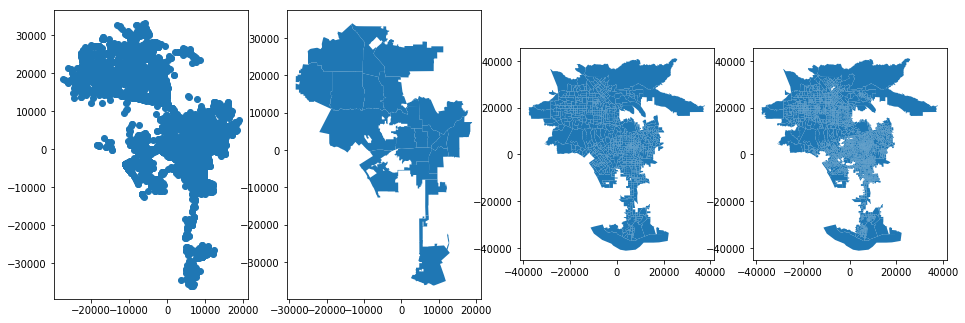

In [9]:
fig, axes = matplotlib.pyplot.subplots(ncols=4, figsize=(16, 12))

for ax in axes:
    ax.set_aspect('equal')
    
arrests.plot(ax=axes[0])
precincts.plot(ax=axes[1])
tracts.plot(ax=axes[2])
bgs.plot(ax=axes[3]);